# Buenos Aires: Ciudad de 15 Minutos — v3
### Análisis a nivel de barrio + equidad urbana por ingreso

---

Esta versión extiende el análisis de v2 en dos dimensiones:

1. **Resolución de barrio**: en lugar de las 15 comunas, usamos los 48 barrios como unidad de análisis. Esto revela heterogeneidades internas que el nivel de comuna oculta (ej: dentro de la Comuna 1 conviven Puerto Madero y La Boca).

2. **Equidad urbana**: cruzamos el índice de accesibilidad con el ingreso per cápita familiar (IPCF) promedio por comuna. El objetivo es responder: *¿son las zonas con menos servicios también las más pobres?* Si la respuesta es sí, la brecha de accesibilidad es también una brecha social.

| Categoría | Datos |
|---|---|
| **Cuidarse** | Hospitales, CESAC, centros privados |
| **Educarse** | Establecimientos educativos |
| **Abastecerse** | Habilitaciones comerciales de alimentos 2024 |
| **Descansar** | Espacios verdes, polideportivos, culturales, clubes |

**Fuente de datos:** [Buenos Aires Data](https://data.buenosaires.gob.ar) · Encuesta Anual de Hogares GCBA

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import folium
from folium import Choropleth, GeoJson
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

DATA_DIR   = "data"
CRS_GEO    = "EPSG:4326"
CRS_METRIC = "EPSG:3857"

plt.rcParams.update({'figure.dpi': 120, 'axes.titlesize': 13, 'axes.labelsize': 11})
print("Librerías cargadas.")

Librerías cargadas.


## 1. Base geográfica — Barrios

In [2]:
# Barrios (GeoJSON en WGS84)
barrios = gpd.read_file(f"{DATA_DIR}/barrios.geojson").to_crs(CRS_GEO)
barrios["COMUNA"] = barrios["COMUNA"].astype(float).astype(int)
barrios = barrios[["BARRIO", "COMUNA", "geometry"]].copy()

# Área en km² en proyección métrica
barrios_m = barrios.to_crs(CRS_METRIC).copy()
barrios_m["area_km2"] = barrios_m.geometry.area / 1_000_000
barrios["area_km2"] = barrios_m["area_km2"].values

# Límites de CABA para filtros y visualizaciones
ba_xmin, ba_ymin, ba_xmax, ba_ymax = barrios.total_bounds

print(f"Barrios cargados: {len(barrios)}")
print(barrios[["BARRIO", "COMUNA", "area_km2"]].sort_values("COMUNA").to_string())

Barrios cargados: 48
               BARRIO  COMUNA   area_km2
19          SAN TELMO       1   1.824001
45             RETIRO       1   6.674420
40      PUERTO MADERO       1   7.459397
41          MONSERRAT       1   3.253705
42        SAN NICOLAS       1   3.386737
11       CONSTITUCION       1   3.111627
44           RECOLETA       2   9.342820
24          BALVANERA       3   6.425525
12      SAN CRISTOBAL       3   3.025265
32      NUEVA POMPEYA       4   7.334295
29           BARRACAS       4  11.779675
16   PARQUE PATRICIOS       4   5.543150
47               BOCA       4   7.456318
13              BOEDO       5   3.863874
4             ALMAGRO       5   5.994155
5           CABALLITO       6  10.139743
9              FLORES       7  12.720707
31   PARQUE CHACABUCO       7   5.674246
35      VILLA SOLDATI       8  12.873703
34    VILLA RIACHUELO       8   6.275590
18       VILLA LUGANO       8  13.777732
30  PARQUE AVELLANEDA       9   7.009887
38            LINIERS       9   6.47

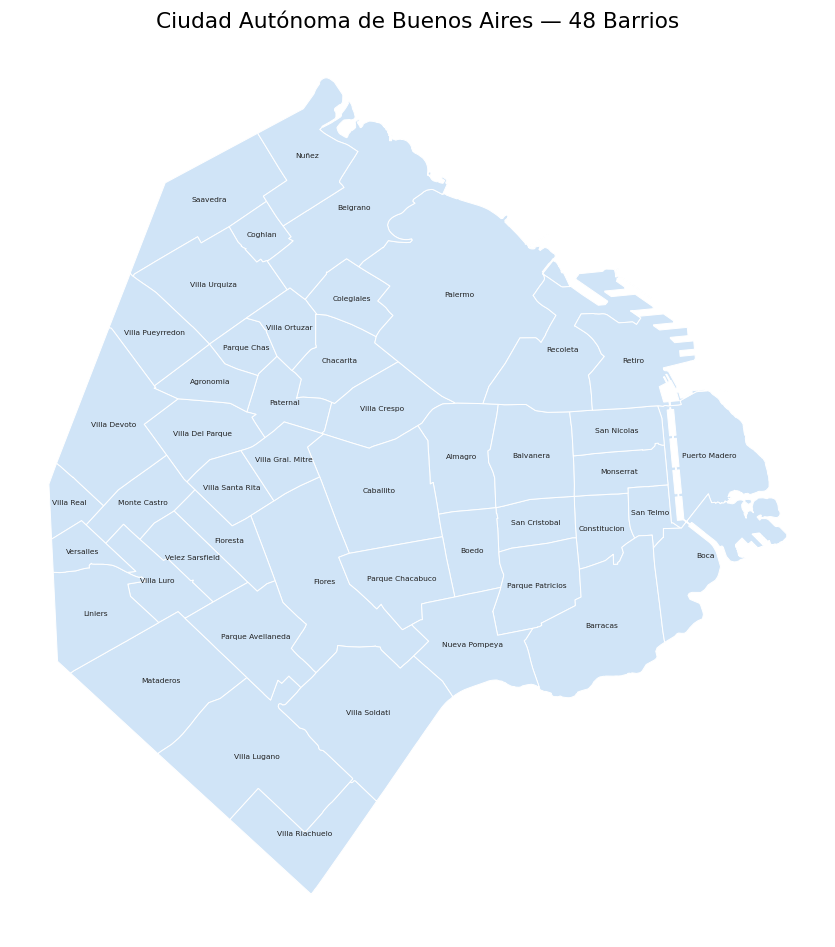

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
barrios.plot(ax=ax, edgecolor="white", facecolor="#d0e4f7", linewidth=0.6)

# Anotar cada barrio con su nombre (fuente pequeña)
for _, row in barrios.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row["BARRIO"].title(), ha="center", va="center",
            fontsize=4.5, color="#222", wrap=True)

ax.set_title("Ciudad Autónoma de Buenos Aires — 48 Barrios")
ax.axis("off")
plt.tight_layout()
plt.show()

## 2. Capas de servicios

In [4]:
# ─── SALUD ───────────────────────────────────────────────────────────────────
hospitales = gpd.read_file(f"{DATA_DIR}/hospitales.geojson").to_crs(CRS_GEO)

cesac_raw = pd.read_csv(f"{DATA_DIR}/centros_salud_nivel_1_cesac.csv")
cesac = gpd.GeoDataFrame(
    cesac_raw,
    geometry=gpd.GeoSeries.from_wkt(cesac_raw["geometry"]),
    crs=CRS_GEO
)

priv_raw = pd.read_csv(f"{DATA_DIR}/centros_de_salud_privado.csv",
                       sep=";", decimal=",", encoding="latin-1").dropna(subset=["long", "lat"])
privados = gpd.GeoDataFrame(
    priv_raw,
    geometry=gpd.points_from_xy(priv_raw["long"], priv_raw["lat"]),
    crs=CRS_GEO
)

# ─── EDUCACIÓN ───────────────────────────────────────────────────────────────
edu_raw = pd.read_csv(f"{DATA_DIR}/establecimientos_educativos.csv")
educacion = gpd.GeoDataFrame(
    edu_raw,
    geometry=gpd.GeoSeries.from_wkt(edu_raw["geometry"]),
    crs="EPSG:9498"
).to_crs(CRS_GEO)

# ─── ABASTECIMIENTO ──────────────────────────────────────────────────────────
manz_raw = pd.read_csv(f"{DATA_DIR}/manzanas_catastrales.csv", encoding="utf-8-sig")
manz_gdf = gpd.GeoDataFrame(
    manz_raw,
    geometry=gpd.GeoSeries.from_wkt(manz_raw["geometry"]),
    crs=CRS_GEO
)
manz_gdf["sec_num"] = manz_gdf["sm"].str.split(" - ").str[0].str.strip().str.extract(r'^(\d+)')
manz_gdf["man_num"] = manz_gdf["sm"].str.split(" - ").str[1].str.strip().str.extract(r'^(\d+)')
manz_gdf = manz_gdf.dropna(subset=["sec_num", "man_num"])
manz_gdf["sec_num"] = manz_gdf["sec_num"].astype(int)
manz_gdf["man_num"] = manz_gdf["man_num"].astype(int)
manz_join = (
    manz_gdf[["sec_num", "man_num", "geometry"]]
    .groupby(["sec_num", "man_num"], as_index=False)
    .first()
)

hab_raw = pd.read_csv(f"{DATA_DIR}/habilitaciones-aprobadas2024.csv", sep=";", encoding="latin-1")
KEYWORDS_ALIMENTOS = [
    "SUPERMERC", "AUTOSERVICIO", "MINIMERCADO", "MINIMARKET",
    "ALMAC", "VERDUR", "FRUTER", "CARNIC", "PESCAD",
    "PANADE", "DIETET", "FIAMBR", "ROTISER", "ABASTO",
    "TAMBO", "PROVISION", "ALIMENT"
]
patron = "|".join(KEYWORDS_ALIMENTOS)
mask = (
    hab_raw["DescripcionRubro"].str.upper().str.contains(patron, na=False) |
    hab_raw["DescripcionSubRubro"].str.upper().str.contains(patron, na=False)
)
hab_alim = hab_raw[mask].copy()
hab_alim["sec_num"] = pd.to_numeric(hab_alim["Seccion"], errors="coerce")
hab_alim["man_num"] = pd.to_numeric(hab_alim["Manzana"], errors="coerce")
hab_alim = hab_alim.dropna(subset=["sec_num", "man_num"])
hab_alim[["sec_num", "man_num"]] = hab_alim[["sec_num", "man_num"]].astype(int)
hab_joined = hab_alim.merge(manz_join[["sec_num", "man_num", "geometry"]], on=["sec_num", "man_num"], how="left")
hab_geo = hab_joined.dropna(subset=["geometry"]).copy()
hab_geo["geometry"] = hab_geo["geometry"].apply(lambda g: g.centroid)
abastecimiento = gpd.GeoDataFrame(hab_geo, geometry="geometry", crs=CRS_GEO)

# ─── DESCANSO ────────────────────────────────────────────────────────────────
ev = gpd.read_file(f"{DATA_DIR}/espacio_verde_publico.geojson").to_crs(CRS_GEO)
polideportivos = gpd.read_file(f"{DATA_DIR}/polideportivos.geojson").to_crs(CRS_GEO)

cult_raw = pd.read_excel(f"{DATA_DIR}/espacios-culturales.xlsx", engine="openpyxl")
cult_raw = cult_raw.dropna(subset=["LONGITUD", "LATITUD"])
EXCLUIR_CULTURALES = ["LIBRERIA", "DISQUERIA"]
cult_filtrado = cult_raw[~cult_raw["FUNCION_PRINCIPAL"].isin(EXCLUIR_CULTURALES)]
culturales = gpd.GeoDataFrame(
    cult_filtrado,
    geometry=gpd.points_from_xy(cult_filtrado["LONGITUD"], cult_filtrado["LATITUD"]),
    crs=CRS_GEO
)

club_raw = pd.read_csv(f"{DATA_DIR}/clubes.csv").dropna(subset=["long", "lat"])
clubes = gpd.GeoDataFrame(
    club_raw,
    geometry=gpd.points_from_xy(club_raw["long"], club_raw["lat"]),
    crs=CRS_GEO
)

# Filtrar coordenadas fuera de CABA
culturales = culturales.cx[ba_xmin:ba_xmax, ba_ymin:ba_ymax]
clubes     = clubes.cx[ba_xmin:ba_xmax, ba_ymin:ba_ymax]

print(f"Hospitales:          {len(hospitales):>4}")
print(f"CESAC:               {len(cesac):>4}")
print(f"Centros privados:    {len(privados):>4}")
print(f"Establec. educativos:{len(educacion):>4}")
print(f"Comercios alimentos: {len(abastecimiento):>4}")
print(f"Espacios verdes:     {len(ev):>4}")
print(f"Polideportivos:      {len(polideportivos):>4}")
print(f"Espacios culturales: {len(culturales):>4}")
print(f"Clubes:              {len(clubes):>4}")

Hospitales:            36
CESAC:                 50
Centros privados:      65
Establec. educativos:2767
Comercios alimentos: 3366
Espacios verdes:     2176
Polideportivos:        16
Espacios culturales: 2612
Clubes:               290


## 3. Análisis espacial por barrio

In [5]:
barrios_m = barrios.to_crs(CRS_METRIC).copy()

def contar_por_barrio(gdf, col_nombre):
    """Cuenta puntos de servicio dentro de cada barrio."""
    s = gdf.to_crs(CRS_METRIC)[["geometry"]].copy()
    b = barrios_m[["BARRIO", "geometry"]].copy()
    joined = gpd.sjoin(s, b, how="left", predicate="within")
    return joined.groupby("BARRIO").size().reset_index(name=col_nombre)

def area_verde_por_barrio():
    """Calcula m² de espacios verdes dentro de cada barrio."""
    ev_m  = ev.to_crs(CRS_METRIC)[["geometry"]].copy()
    bar_m = barrios_m[["BARRIO", "geometry"]].copy()
    clip  = gpd.overlay(ev_m, bar_m, how="intersection")
    clip["area_verde_m2"] = clip.geometry.area
    return clip.groupby("BARRIO")["area_verde_m2"].sum().reset_index()

print("Calculando spatial joins por barrio...")
n_hospitales     = contar_por_barrio(hospitales,    "hospitales")
n_cesac          = contar_por_barrio(cesac,          "cesac")
n_privados       = contar_por_barrio(privados,       "salud_privada")
n_educacion      = contar_por_barrio(educacion,      "educacion")
n_abastecimiento = contar_por_barrio(abastecimiento, "abastecimiento")
n_polideportivos = contar_por_barrio(polideportivos, "polideportivos")
n_culturales     = contar_por_barrio(culturales,     "culturales")
n_clubes         = contar_por_barrio(clubes,         "clubes")
df_verde         = area_verde_por_barrio()
print("Listo.")

Calculando spatial joins por barrio...
Listo.


In [6]:
# DataFrame maestro por barrio
df = barrios[["BARRIO", "COMUNA", "area_km2"]].copy()

for df_i in [n_hospitales, n_cesac, n_privados, n_educacion,
             n_abastecimiento, n_polideportivos, n_culturales, n_clubes, df_verde]:
    df = df.merge(df_i, on="BARRIO", how="left")

df = df.fillna(0)
df["pct_verde"] = df["area_verde_m2"] / (df["area_km2"] * 1_000_000) * 100

print("Conteos por barrio (primeros 10):")
df[["BARRIO", "COMUNA", "area_km2", "hospitales", "cesac", "educacion",
    "abastecimiento", "pct_verde", "culturales", "clubes"]].sort_values("BARRIO").head(10).round(2)

Conteos por barrio (primeros 10):


,BARRIO,COMUNA,area_km2,hospitales,cesac,educacion,abastecimiento,pct_verde,culturales,clubes
27,AGRONOMIA,15,3.14,0.0,0.0,22,13.0,0.19,8,5.0
4,ALMAGRO,5,5.99,1.0,1.0,123,136.0,0.26,136,9.0
24,BALVANERA,3,6.43,1.0,1.0,151,229.0,0.71,186,4.0
29,BARRACAS,4,11.78,6.0,8.0,104,32.0,3.36,52,7.0
43,BELGRANO,13,11.82,1.0,0.0,104,153.0,13.22,78,7.0
47,BOCA,4,7.46,2.0,2.0,48,36.0,2.18,67,4.0
13,BOEDO,5,3.86,0.0,0.0,32,42.0,0.47,47,9.0
5,CABALLITO,6,10.14,4.0,0.0,146,143.0,2.53,86,8.0
0,CHACARITA,15,4.61,0.0,0.0,33,38.0,3.24,62,2.0
21,COGHLAN,12,1.89,1.0,0.0,10,9.0,1.38,8,2.0


## 4. Índice de Ciudad de 15 Minutos por barrio

In [7]:
# Dimensiones brutas
df["dim_salud"]          = (df["hospitales"] * 3 + df["cesac"] * 2 + df["salud_privada"] * 0.1) / df["area_km2"]
df["dim_educacion"]      = df["educacion"]      / df["area_km2"]
df["dim_abastecimiento"] = df["abastecimiento"] / df["area_km2"]

# Sub-componentes de descanso
df["sub_verde"]   = df["pct_verde"]
df["sub_deporte"] = df["polideportivos"] / df["area_km2"]
df["sub_cultura"] = df["culturales"]     / df["area_km2"]
df["sub_clubes"]  = df["clubes"]         / df["area_km2"]

SUBS_DESCANSO = ["sub_verde", "sub_deporte", "sub_cultura", "sub_clubes"]
scaler_sub = MinMaxScaler(feature_range=(0, 100))
df[SUBS_DESCANSO] = scaler_sub.fit_transform(df[SUBS_DESCANSO])
df["dim_descanso"] = df[SUBS_DESCANSO].mean(axis=1)

DIMS        = ["dim_salud", "dim_educacion", "dim_abastecimiento", "dim_descanso"]
DIMS_LABELS = ["Salud", "Educación", "Abastecimiento", "Descanso"]

scaler = MinMaxScaler(feature_range=(0, 100))
df[DIMS] = scaler.fit_transform(df[DIMS])

df["score_15min"] = df[DIMS].mean(axis=1)
df = df.reset_index(drop=True)

print("Top 10 barrios — Índice de Ciudad de 15 minutos:")
df[["BARRIO", "COMUNA", "score_15min"] + DIMS].sort_values("score_15min", ascending=False).head(10).round(1)

Top 10 barrios — Índice de Ciudad de 15 minutos:


,BARRIO,COMUNA,score_15min,dim_salud,dim_educacion,dim_abastecimiento,dim_descanso
12,SAN CRISTOBAL,3,73.1,54.6,77.9,80.8,79.0
42,SAN NICOLAS,1,70.0,0.0,82.2,100.0,97.8
19,SAN TELMO,1,64.5,35.5,97.9,24.7,100.0
24,BALVANERA,3,58.2,28.3,100.0,76.4,28.0
41,MONSERRAT,1,55.1,1.0,61.2,87.0,71.1
16,PARQUE PATRICIOS,4,54.7,100.0,47.8,12.0,58.9
4,ALMAGRO,5,51.3,30.3,86.8,48.6,39.6
10,FLORESTA,10,50.9,18.9,57.8,55.5,71.5
29,BARRACAS,4,44.9,93.8,35.0,5.8,45.0
44,RECOLETA,2,40.9,37.1,49.9,51.2,25.4


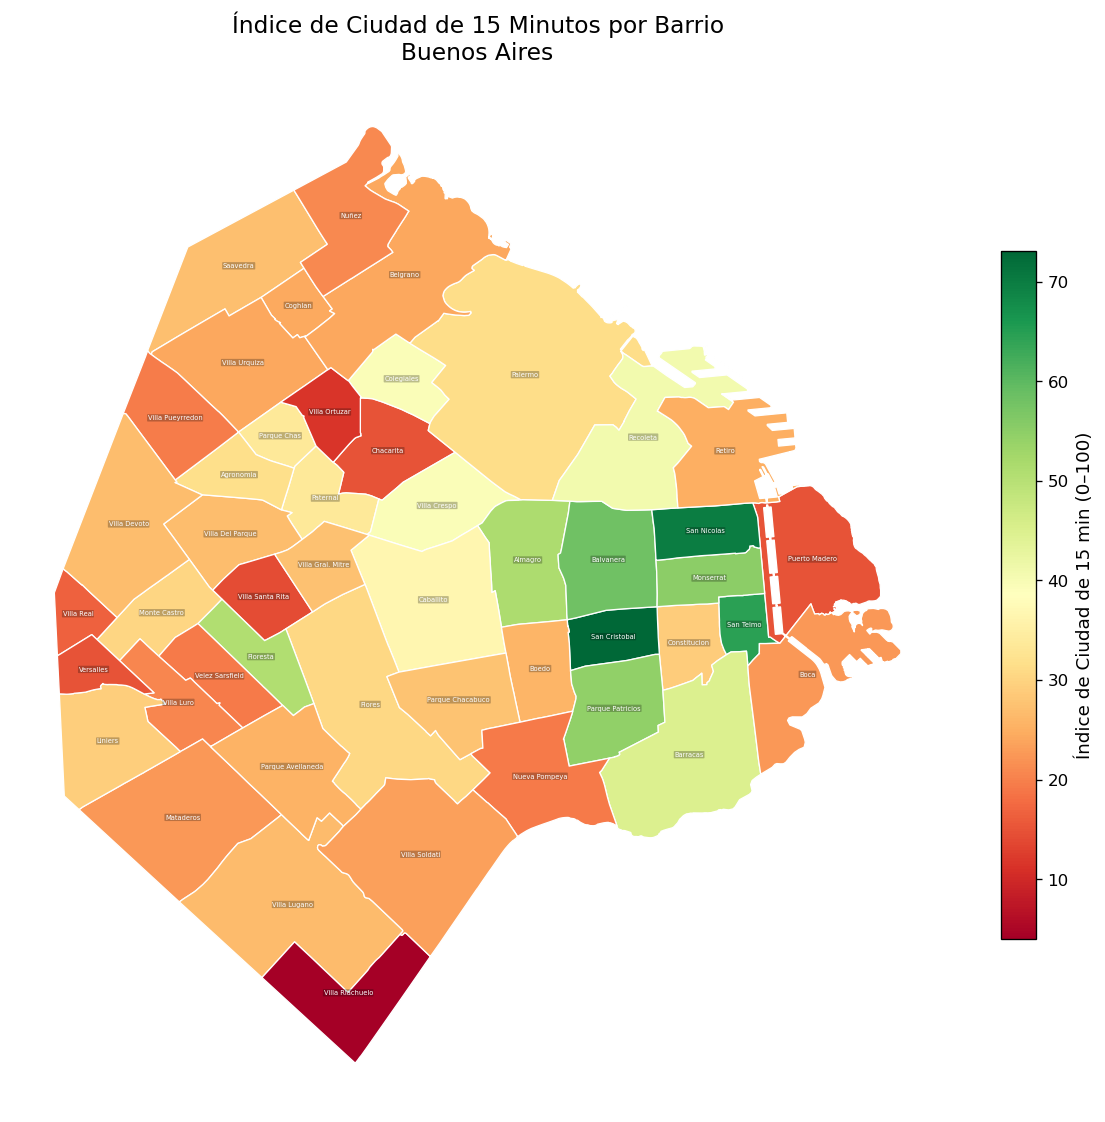

In [8]:
# Mapa coroplético por barrio
gdf_result = barrios.merge(df[["BARRIO"] + DIMS + ["score_15min"]], on="BARRIO")

fig, ax = plt.subplots(figsize=(10, 10))
gdf_result.plot(
    column="score_15min", cmap="RdYlGn", legend=True, ax=ax,
    edgecolor="white", linewidth=0.8,
    legend_kwds={"label": "Índice de Ciudad de 15 min (0–100)", "shrink": 0.6}
)
for _, row in gdf_result.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row["BARRIO"].title(),
            ha="center", va="center", fontsize=4, color="white",
            bbox=dict(boxstyle="round,pad=0.1", fc="black", alpha=0.25, lw=0))
ax.set_title("Índice de Ciudad de 15 Minutos por Barrio\nBuenos Aires", fontsize=14, pad=12)
ax.axis("off")
plt.tight_layout()
plt.show()

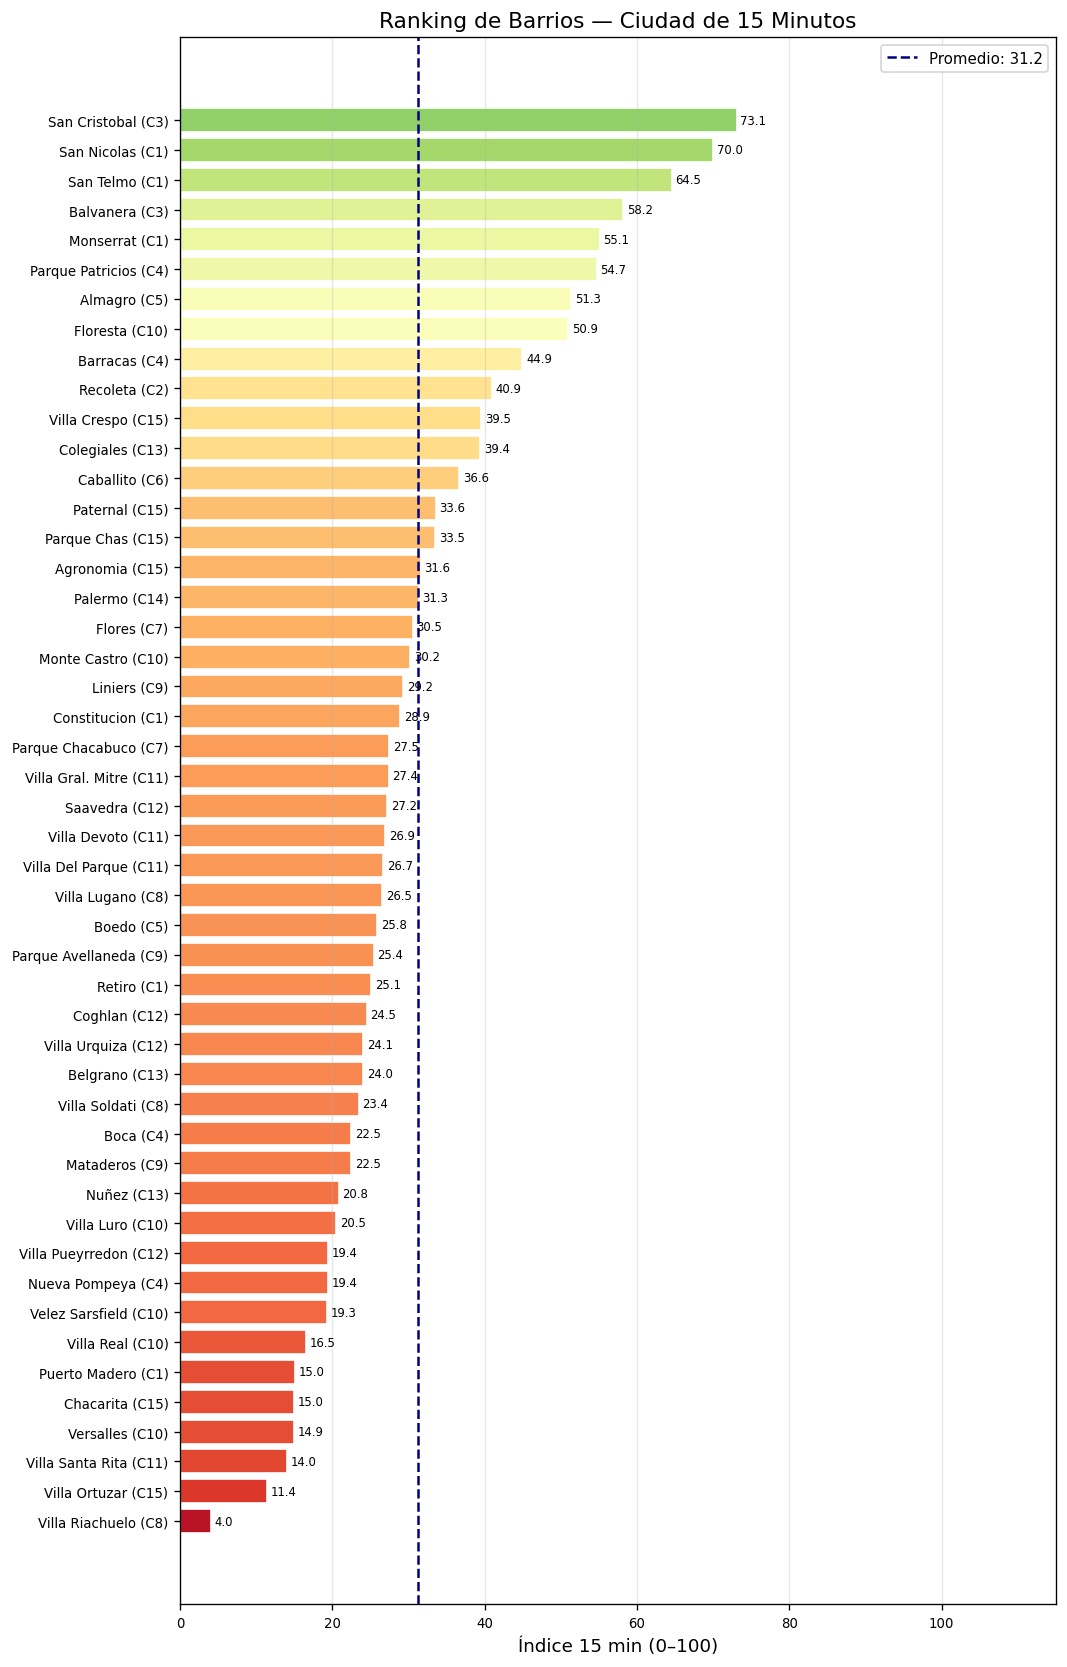

In [9]:
# Ranking de los 48 barrios
ranking = df[["BARRIO", "COMUNA", "score_15min"] + DIMS].sort_values("score_15min", ascending=True)
norm = Normalize(vmin=0, vmax=100)
cmap = cm.get_cmap("RdYlGn")

fig, ax = plt.subplots(figsize=(9, 14))
colors = [cmap(norm(v)) for v in ranking["score_15min"]]
bars = ax.barh(
    ranking["BARRIO"].str.title() + " (C" + ranking["COMUNA"].astype(str) + ")",
    ranking["score_15min"], color=colors, edgecolor="white"
)
for bar, val in zip(bars, ranking["score_15min"]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}", va="center", fontsize=7)
promedio = ranking["score_15min"].mean()
ax.axvline(x=promedio, color="navy", linestyle="--", linewidth=1.5,
           label=f"Promedio: {promedio:.1f}")
ax.set_xlabel("Índice 15 min (0–100)")
ax.set_title("Ranking de Barrios — Ciudad de 15 Minutos", fontsize=13)
ax.set_xlim(0, 115)
ax.legend(fontsize=9)
ax.tick_params(labelsize=8)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Equidad urbana — Accesibilidad e ingreso

Cruzamos el índice de accesibilidad con el **Ingreso Per Cápita Familiar (IPCF)** promedio por comuna.

Fuente: Encuesta Anual de Hogares (EAH) 2023 — GCBA / IDECBA  
Serie completa: [estadisticaciudad.gob.ar](https://www.estadisticaciudad.gob.ar/eyc/?p=82456)

> Los valores de IPCF están expresados como **índice relativo al promedio de CABA = 100**.  
> Un valor de 180 significa que esa comuna tiene un ingreso 80% superior al promedio de la ciudad.

In [29]:
# IPCF por comuna — Encuesta Anual de Hogares 2024 (GCBA/IDECBA)
# Archivo: MT_eah_2417.xlsx — una hoja por año, columnas: Comuna | Promedio IPCF
# Fuente: https://www.estadisticaciudad.gob.ar/eyc/?p=82456

ipcf_raw = pd.read_excel(
    f"{DATA_DIR}/MT_eah_2417.xlsx",
    sheet_name="2024",
    header=None,
    names=["COMUNA", "ipcf_pesos"]
)

# Forzar conversión numérica en ambas columnas y descartar filas no válidas
ipcf_raw["COMUNA"]     = pd.to_numeric(ipcf_raw["COMUNA"],     errors="coerce")
ipcf_raw["ipcf_pesos"] = pd.to_numeric(ipcf_raw["ipcf_pesos"], errors="coerce")
ipcf_raw = ipcf_raw.dropna(subset=["COMUNA", "ipcf_pesos"]).copy()
ipcf_raw["COMUNA"] = ipcf_raw["COMUNA"].astype(int)
ipcf_raw = ipcf_raw[ipcf_raw["COMUNA"].between(1, 15)].reset_index(drop=True)

# Convertir a índice relativo: promedio comunas = 100
media_pesos = ipcf_raw["ipcf_pesos"].mean()
ipcf_raw["ipcf"] = (ipcf_raw["ipcf_pesos"] / media_pesos * 100).round(1)

df_ipcf = ipcf_raw[["COMUNA", "ipcf"]].copy()

# Asignar IPCF a cada barrio
df = df.merge(df_ipcf, on="COMUNA", how="left")

print("IPCF por comuna — EAH 2024 (índice relativo, promedio comunas = 100):")
print(df_ipcf.to_string(index=False))
print(f"\nIPCF mínimo: C{ipcf_raw.loc[ipcf_raw['ipcf'].idxmin(), 'COMUNA']} ({ipcf_raw['ipcf'].min():.1f})")
print(f"IPCF máximo: C{ipcf_raw.loc[ipcf_raw['ipcf'].idxmax(), 'COMUNA']} ({ipcf_raw['ipcf'].max():.1f})")
print(f"Brecha máx/mín: {ipcf_raw['ipcf'].max() / ipcf_raw['ipcf'].min():.1f}x")

IPCF por comuna — EAH 2024 (índice relativo, promedio comunas = 100):
 COMUNA  ipcf
      1  90.5
      2 136.4
      3  89.3
      4  74.7
      5 112.0
      6 115.1
      7  82.2
      8  52.4
      9  78.9
     10  88.5
     11  98.8
     12 112.6
     13 125.5
     14 134.1
     15 109.0

IPCF mínimo: C8 (52.4)
IPCF máximo: C2 (136.4)
Brecha máx/mín: 2.6x


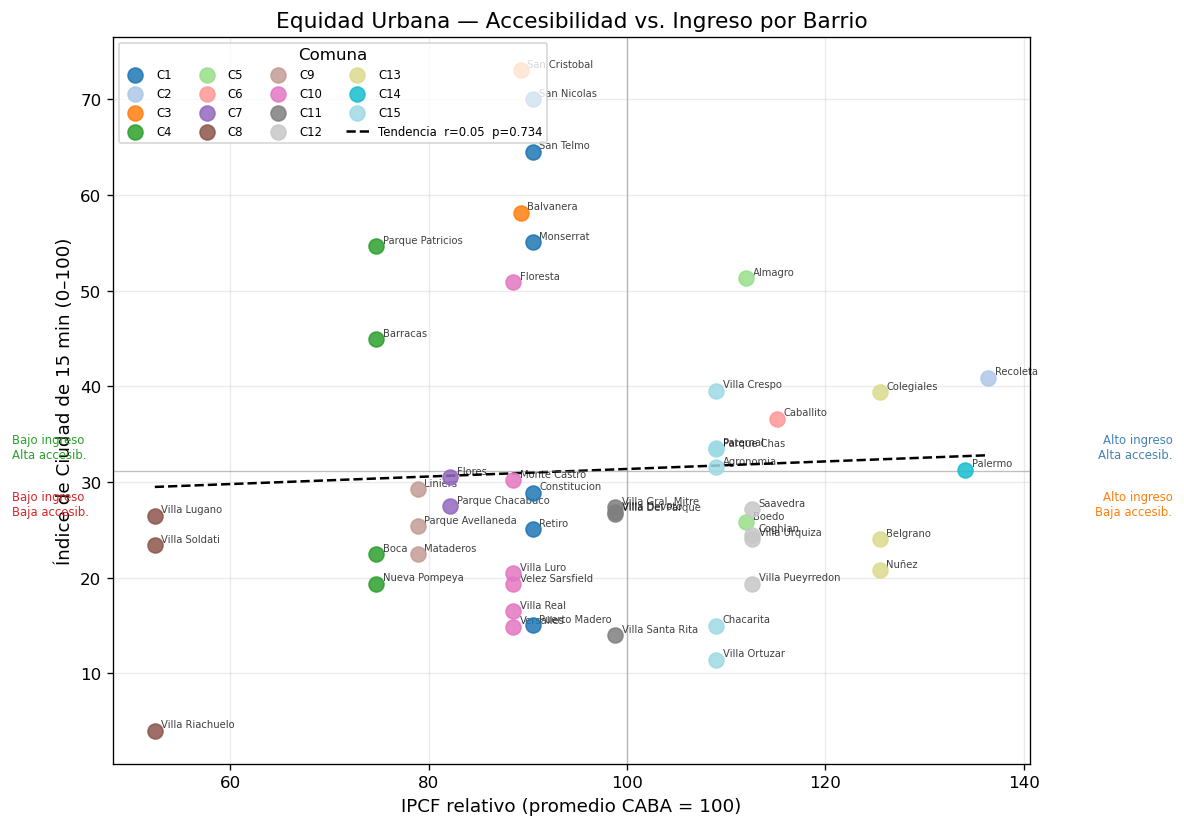

Correlación Pearson: r = 0.050  (p = 0.7342)
Un r positivo indica que mayor ingreso → mayor accesibilidad.


In [30]:
# Scatter: score de accesibilidad vs. ingreso — un punto por barrio
from scipy import stats

x = df["ipcf"].values
y = df["score_15min"].values
slope, intercept, r, p, _ = stats.linregress(x, y)
x_line = np.linspace(x.min(), x.max(), 100)

fig, ax = plt.subplots(figsize=(10, 7))

# Colorear por comuna
comunas_unicas = sorted(df["COMUNA"].unique())
cmap_c = cm.get_cmap("tab20", len(comunas_unicas))
for i, com in enumerate(comunas_unicas):
    sub = df[df["COMUNA"] == com]
    ax.scatter(sub["ipcf"], sub["score_15min"],
               color=cmap_c(i), s=80, zorder=5, label=f"C{com}", alpha=0.85)
    for _, row in sub.iterrows():
        ax.annotate(row["BARRIO"].title(),
                    (row["ipcf"], row["score_15min"]),
                    fontsize=6, alpha=0.75, xytext=(4, 2), textcoords="offset points")

# Línea de tendencia
ax.plot(x_line, slope * x_line + intercept, color="black", linewidth=1.5,
        linestyle="--", label=f"Tendencia  r={r:.2f}  p={'<0.001' if p < 0.001 else f'{p:.3f}'}")

# Cuadrantes
ax.axvline(100, color="gray", linewidth=0.8, alpha=0.5)
ax.axhline(df["score_15min"].mean(), color="gray", linewidth=0.8, alpha=0.5)
ax.text(38, df["score_15min"].mean() + 1, "Bajo ingreso\nAlta accesib.", fontsize=7,
        color="#2ca02c", va="bottom")
ax.text(155, df["score_15min"].mean() + 1, "Alto ingreso\nAlta accesib.", fontsize=7,
        color="steelblue", va="bottom", ha="right")
ax.text(38, df["score_15min"].mean() - 2, "Bajo ingreso\nBaja accesib.", fontsize=7,
        color="#d62728", va="top")
ax.text(155, df["score_15min"].mean() - 2, "Alto ingreso\nBaja accesib.", fontsize=7,
        color="#ff7f0e", va="top", ha="right")

ax.set_xlabel("IPCF relativo (promedio CABA = 100)", fontsize=11)
ax.set_ylabel("Índice de Ciudad de 15 min (0–100)", fontsize=11)
ax.set_title("Equidad Urbana — Accesibilidad vs. Ingreso por Barrio", fontsize=13)
ax.legend(fontsize=7, ncol=4, loc="upper left", title="Comuna")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

print(f"Correlación Pearson: r = {r:.3f}  (p = {p:.4f})")
print(f"Un r positivo indica que mayor ingreso → mayor accesibilidad.")

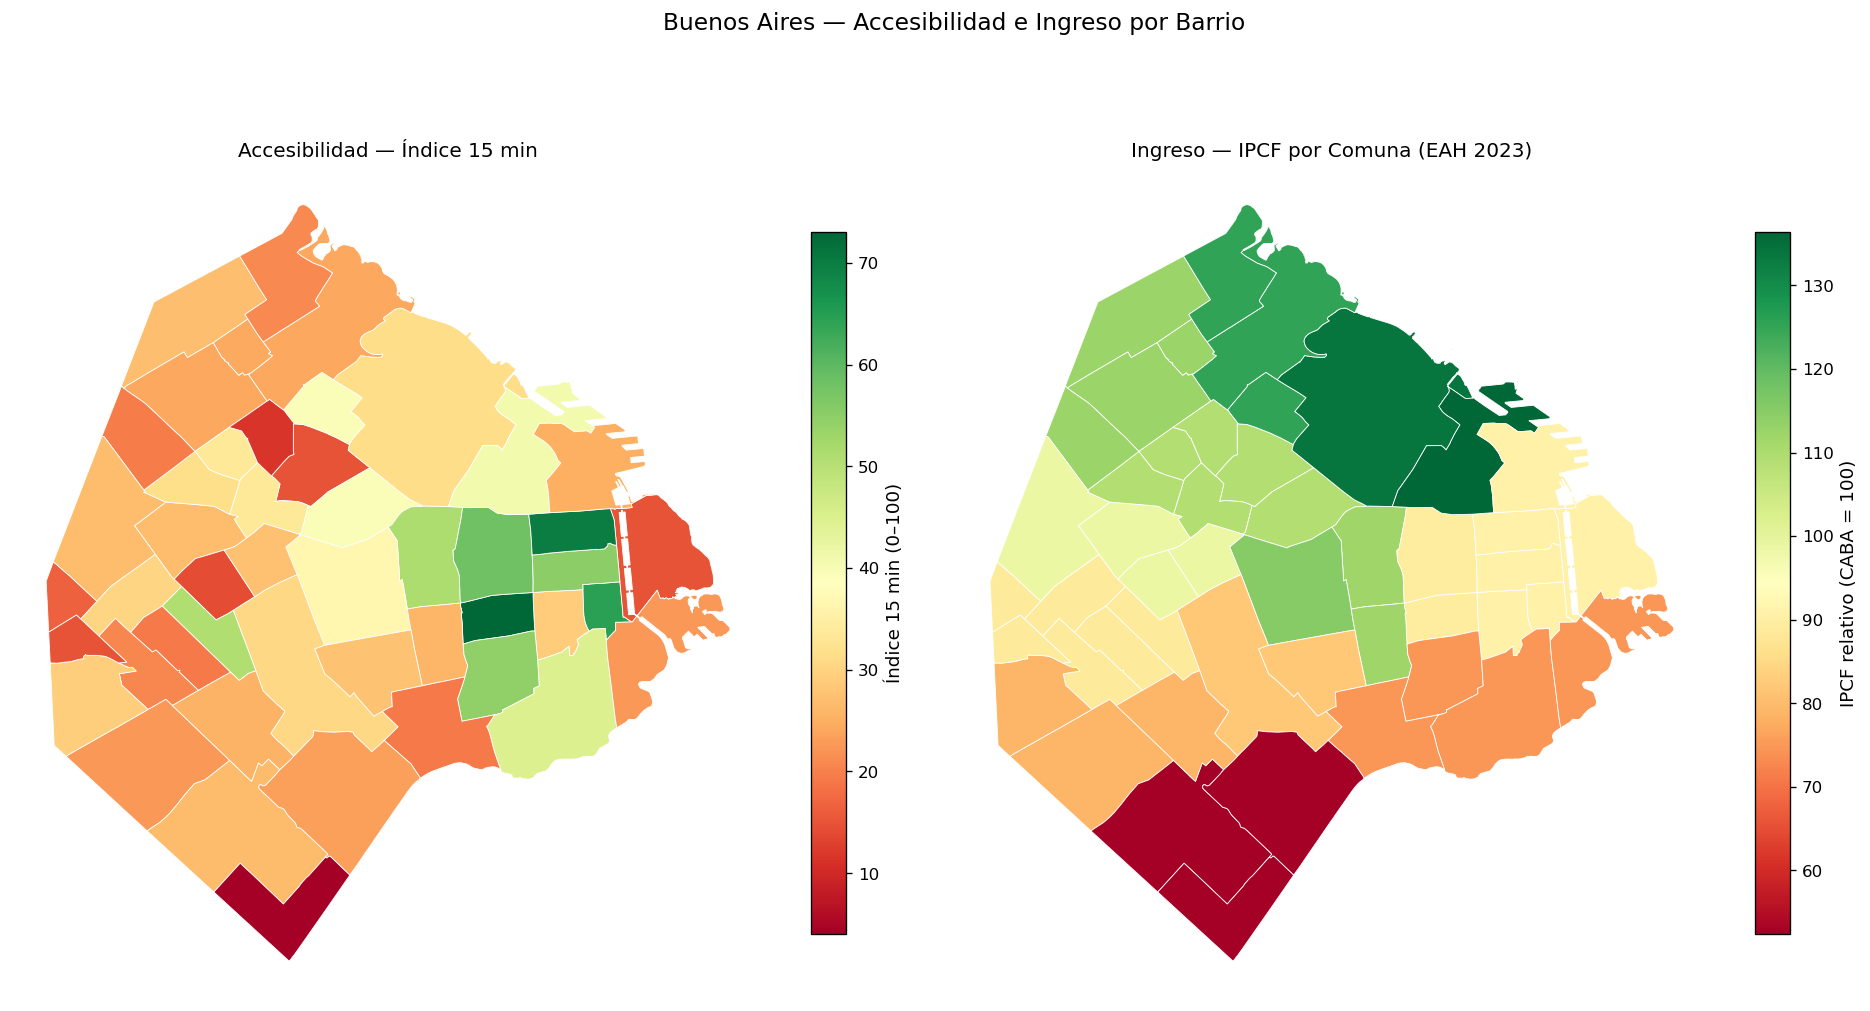

In [31]:
# Mapa dual: izquierda = accesibilidad, derecha = ingreso por comuna
# df ya tiene ipcf desde la celda anterior; no incluimos COMUNA de df para evitar columnas duplicadas
gdf_barrios_full = barrios.merge(df[["BARRIO", "score_15min", "ipcf"] + DIMS], on="BARRIO")

fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# — Accesibilidad
ax = axes[0]
gdf_barrios_full.plot(
    column="score_15min", cmap="RdYlGn", legend=True, ax=ax,
    edgecolor="white", linewidth=0.5,
    legend_kwds={"label": "Índice 15 min (0–100)", "shrink": 0.7}
)
ax.set_title("Accesibilidad — Índice 15 min", fontsize=12)
ax.axis("off")

# — Ingreso (IPCF por comuna, coloreado por barrio)
ax = axes[1]
gdf_barrios_full.plot(
    column="ipcf", cmap="RdYlGn", legend=True, ax=ax,
    edgecolor="white", linewidth=0.5,
    legend_kwds={"label": "IPCF relativo (CABA = 100)", "shrink": 0.7}
)
ax.set_title("Ingreso — IPCF por Comuna (EAH 2023)", fontsize=12)
ax.axis("off")

plt.suptitle("Buenos Aires — Accesibilidad e Ingreso por Barrio", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

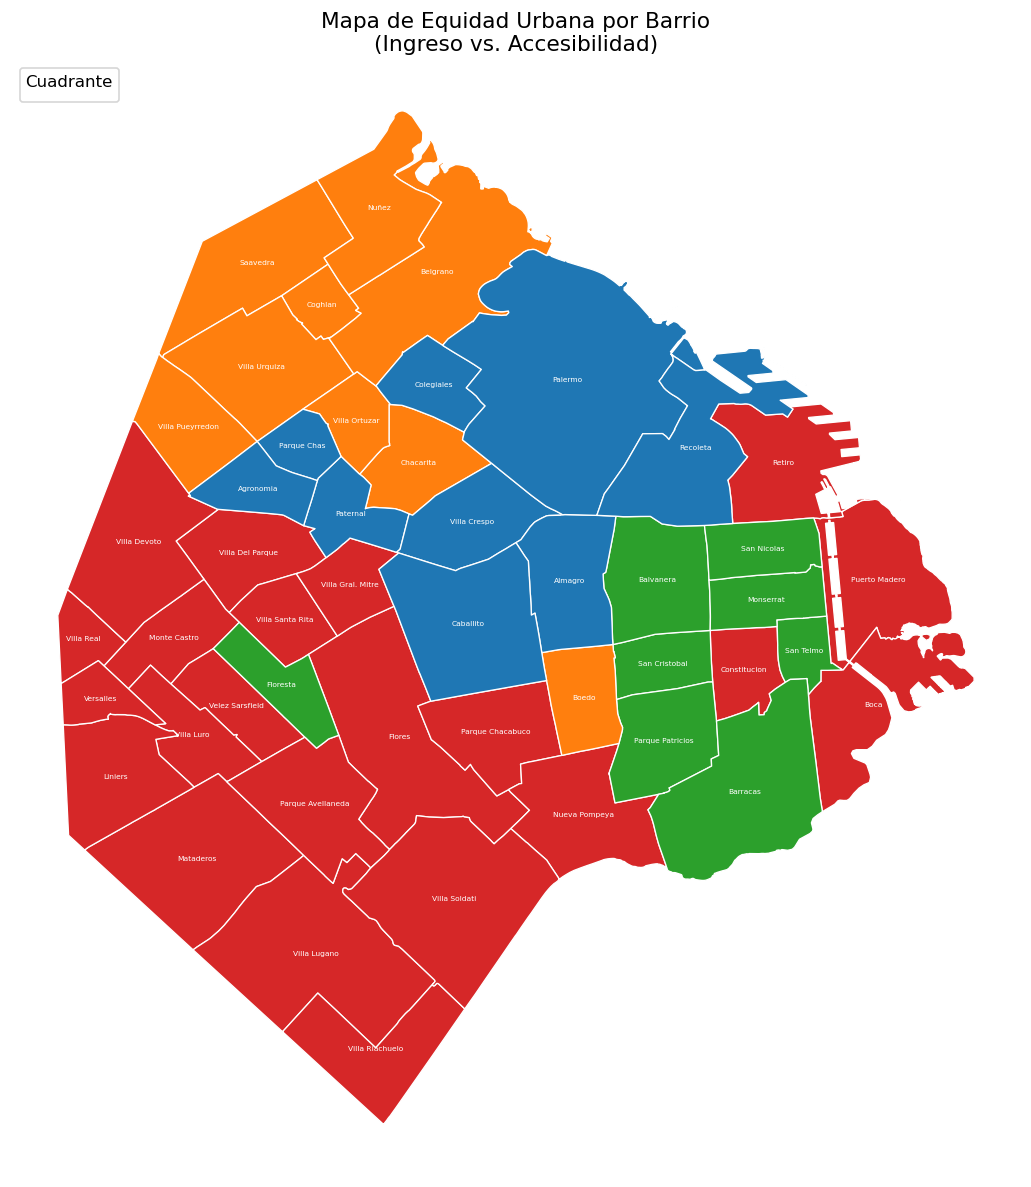

Barrios en doble vulnerabilidad (bajo ingreso + baja accesibilidad):
           BARRIO  COMUNA  score_15min  ipcf
  VILLA RIACHUELO       8     4.017006  52.4
 VILLA SANTA RITA      11    14.019447  98.8
        VERSALLES      10    14.901900  88.5
    PUERTO MADERO       1    15.032488  90.5
       VILLA REAL      10    16.486436  88.5
  VELEZ SARSFIELD      10    19.324308  88.5
    NUEVA POMPEYA       4    19.376530  74.7
       VILLA LURO      10    20.500245  88.5
        MATADEROS       9    22.473251  78.9
             BOCA       4    22.485545  74.7
    VILLA SOLDATI       8    23.426731  52.4
           RETIRO       1    25.052882  90.5
PARQUE AVELLANEDA       9    25.416169  78.9
     VILLA LUGANO       8    26.502727  52.4
 VILLA DEL PARQUE      11    26.682460  98.8
     VILLA DEVOTO      11    26.882445  98.8
VILLA GRAL. MITRE      11    27.369284  98.8
 PARQUE CHACABUCO       7    27.485733  82.2
     CONSTITUCION       1    28.876859  90.5
          LINIERS       9    29

In [32]:
# Brecha de equidad: barrios con bajo ingreso Y baja accesibilidad
media_score = df["score_15min"].mean()

df["cuadrante"] = "Alto ingreso / Alta accesib."
df.loc[(df["ipcf"] <  100) & (df["score_15min"] >= media_score), "cuadrante"] = "Bajo ingreso / Alta accesib."
df.loc[(df["ipcf"] >= 100) & (df["score_15min"] <  media_score), "cuadrante"] = "Alto ingreso / Baja accesib."
df.loc[(df["ipcf"] <  100) & (df["score_15min"] <  media_score), "cuadrante"] = "Bajo ingreso / Baja accesib."

COLORES_CUADRANTE = {
    "Bajo ingreso / Baja accesib." : "#d62728",  # doble vulnerabilidad
    "Bajo ingreso / Alta accesib." : "#2ca02c",  # pobre pero bien servido
    "Alto ingreso / Baja accesib." : "#ff7f0e",  # rico pero mal servido
    "Alto ingreso / Alta accesib." : "#1f77b4",  # doble ventaja
}

gdf_cuadrantes = barrios.merge(df[["BARRIO", "cuadrante"]], on="BARRIO")

fig, ax = plt.subplots(figsize=(10, 10))
for cuad, color in COLORES_CUADRANTE.items():
    subset = gdf_cuadrantes[gdf_cuadrantes["cuadrante"] == cuad]
    subset.plot(ax=ax, color=color, edgecolor="white", linewidth=0.8, label=cuad)
    for _, row in subset.iterrows():
        c = row.geometry.centroid
        ax.text(c.x, c.y, row["BARRIO"].title(),
                ha="center", va="center", fontsize=4.5, color="white")

ax.legend(loc="upper left", fontsize=9, title="Cuadrante")
ax.set_title("Mapa de Equidad Urbana por Barrio\n(Ingreso vs. Accesibilidad)", fontsize=13)
ax.axis("off")
plt.tight_layout()
plt.show()

print("Barrios en doble vulnerabilidad (bajo ingreso + baja accesibilidad):")
doble_vuln = df[df["cuadrante"] == "Bajo ingreso / Baja accesib."][["BARRIO", "COMUNA", "score_15min", "ipcf"]]
print(doble_vuln.sort_values("score_15min").to_string(index=False))

## 6. Mapa interactivo

In [33]:
gdf_map = gdf_barrios_full.copy()
for col in ["score_15min"] + DIMS + ["ipcf"]:
    gdf_map[col] = gdf_map[col].round(1)

m = folium.Map(location=[-34.62, -58.42], zoom_start=12, tiles="CartoDB positron")

Choropleth(
    geo_data=gdf_map.to_json(),
    data=gdf_map,
    columns=["BARRIO", "score_15min"],
    key_on="feature.properties.BARRIO",
    fill_color="RdYlGn",
    fill_opacity=0.65,
    line_opacity=0.8,
    legend_name="Índice Ciudad de 15 min (0–100)"
).add_to(m)

GeoJson(
    gdf_map[["BARRIO", "COMUNA", "score_15min", "ipcf"] + DIMS + ["geometry"]].to_json(),
    tooltip=folium.features.GeoJsonTooltip(
        fields=["BARRIO", "COMUNA", "score_15min", "ipcf"] + DIMS,
        aliases=["Barrio", "Comuna", "Índice 15 min", "IPCF relativo"] + DIMS_LABELS,
        localize=True
    ),
    style_function=lambda x: {"fillOpacity": 0, "weight": 0}
).add_to(m)

m.save("mapa_ciudad_15min_v3.html")
print("Mapa guardado como mapa_ciudad_15min_v3.html")
m

Mapa guardado como mapa_ciudad_15min_v3.html


## 7. Conclusiones

### Mayor resolución geográfica

El análisis a nivel de barrio revela heterogeneidades que el nivel de comuna ocultaba. Dentro de una misma comuna coexisten barrios con perfiles muy distintos, lo que refuerza la necesidad de planificar intervenciones a escala de barrio, no de comuna.

### Equidad urbana

El cruce entre el índice de accesibilidad y el IPCF por comuna permite identificar cuatro perfiles:

| Cuadrante | Interpretación | Prioridad de intervención |
|---|---|---|
| **Bajo ingreso / Baja accesib.** | Doble vulnerabilidad | **Máxima** |
| **Bajo ingreso / Alta accesib.** | Bien servido pese al ingreso | Media |
| **Alto ingreso / Baja accesib.** | Déficit puntual en zona rica | Baja |
| **Alto ingreso / Alta accesib.** | Doble ventaja | Sin urgencia |

Los barrios en **doble vulnerabilidad** (bajo ingreso y baja accesibilidad) son la prioridad de intervención más clara: necesitan más servicios *y* su población tiene menos recursos para compensar la distancia (transporte privado, servicios privados).

### Limitaciones

- El IPCF está disponible solo a nivel de **comuna**, no de barrio. Barrios dentro de la misma comuna pueden tener ingresos muy distintos.
- La accesibilidad mide **densidad de oferta**, no **distancia caminable real** (próximo paso: isocrona con osmnx).
- El dato de ingreso corresponde a la EAH 2023; puede actualizarse desde [estadisticaciudad.gob.ar](https://www.estadisticaciudad.gob.ar/eyc/?p=82456).